In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.patches import Rectangle
from matplotlib.ticker import EngFormatter
import scipy.signal as sp
from cycler import cycler
from quantiphy import Quantity
formatter0 = EngFormatter(unit='Hz')
rc('font',family='serif')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (16,8)
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')


In [2]:
file = open("data2.raw", "r")
interleaved_data = np.fromfile(file, np.uint8)
file.close()

In [3]:
I_data_raw = interleaved_data[0:len(interleaved_data):2]
Q_data_raw = interleaved_data[1:len(interleaved_data):2]

I_samples = (I_data_raw-127.5)/127.5
Q_samples = (Q_data_raw-127.5)/127.5

complex_data = I_samples + 1j*Q_samples


In [44]:


start = 78179
end = 96008

DATA_I = I_samples[start:end]
DATA_Q = Q_samples[start:end]
DATA_mag = np.abs(complex_data)[start:end]
DATA_I = DATA_I / DATA_mag.max()
DATA_Q = DATA_Q / DATA_mag.max()
DATA_signal = DATA_I + 1j*DATA_Q

fs = 2.4E6 #Carrier frequency of SDR
dt = 1/(fs) #Timestep between samples 
freq = np.fft.fftfreq(len(DATA_signal),dt)

bins=np.arange(0,len(DATA_signal),1)
t=bins*dt

DATA_SIGNAL_O = np.fft.fft(DATA_signal)
DATA_MAG_O = 10*np.log10(np.abs(DATA_SIGNAL_O))
Δ_Φ = np.diff(np.unwrap((np.angle(DATA_signal[2:227]))))
Δ_f = np.median(Δ_Φ)  / (np.pi*2*dt) 
print(" Corse Frequency Offset:",Quantity(Δ_f,'Hz'))

DATA_signal = DATA_signal*(np.cos(2*np.pi*(-1*Δ_f)*t) + 1j*np.sin(2*np.pi*(-1*Δ_f)*t))
DATA_SIGNAL = np.fft.fft(DATA_signal)
DATA_MAG = 10*np.log10(np.abs(DATA_SIGNAL))

DATA_SIGNAL_ABS = np.fft.fft(np.abs(DATA_signal))
DATA_MAG_ABS = 10*np.log10(np.abs(DATA_SIGNAL_ABS))
DATA_SIGNAL_Φ = np.angle(DATA_SIGNAL_ABS)

#Thus we obtain the frequency of the clock by lDBPSKing for the largest spike above the noise.
Index_max = 800+(DATA_MAG_ABS[800:2500].argmax())
f_clk=freq[Index_max]
freq_δ = np.abs(freq[0]-freq[1])/2
#Now need to obtain the phase of the clock.
# I did this by using the index function which searches the array and returns the bin where that value is located
for i, j in enumerate(freq):
    if (f_clk-freq_δ) < j < (f_clk+freq_δ):
            freq_bin=(i)
            

Φ = DATA_SIGNAL_Φ[freq_bin]
f = freq[freq_bin]
ω = 2 * np.pi * f
NCO = np.cos((ω*t)+Φ) + 1j*np.sin((ω*t)+Φ)
NCO = (NCO+1) * (0.4)

peak_bins = sp.find_peaks(np.real(NCO))
symbol_data = []
for k in peak_bins[0]:
        symbol_data.append(DATA_signal[k])
sym_max = np.abs(symbol_data).max()
norm_data = np.real(symbol_data)/sym_max + 1j*np.imag(symbol_data)/sym_max
norm_data = norm_data * np.e**(-1j*np.angle(norm_data[0]))
print(Quantity(Φ))

 Corse Frequency Offset: 388.73 kHz
289.39m


# Carrier Synchronization DBPSK

In [45]:
sd_after=[]
Φ_error = []
Δ_Φ = []
PLL = []
ΔΦ = 0
Φ_e = 0
for i in range (len(norm_data)):
    sd_after.append(norm_data[i])
    if i == 0:
        ΔΦ = np.angle(sd_after[i]*np.conj(norm_data[i]))
        Φ_e += ΔΦ
    else:
        ΔΦ = np.angle(norm_data[i]*np.conj(norm_data[i-1]))
        if (np.pi/4) < np.abs(ΔΦ):
            Φ_e += (ΔΦ - np.pi)
        else:
            Φ_e += ΔΦ
    sd_after[i] = sd_after[i] * np.e**(-1j*Φ_e)
    Φ_error.append(Φ_e)
    Δ_Φ.append(ΔΦ)
    PLL.append(np.e**(-1j*Φ_e))

In [54]:
Δ_Φ = np.angle(sd_after)
Δ_Φ = Δ_Φ *57.2958
data=[]
for i in range(len(Δ_Φ)):
    if 100 < np.abs(Δ_Φ[i]) < 260:
        data.append('1')
    else:
        data.append('0')
        
data = ''.join(data[9:])
message = ""
for i in  range(1,624,8):
    temp_data = data[i:i + 8]
    decimal_data = int(temp_data, 2) 
    message = message + chr(decimal_data)
print(message)

^I just asked my husband if he remembers what today is... Scaring men is easy.


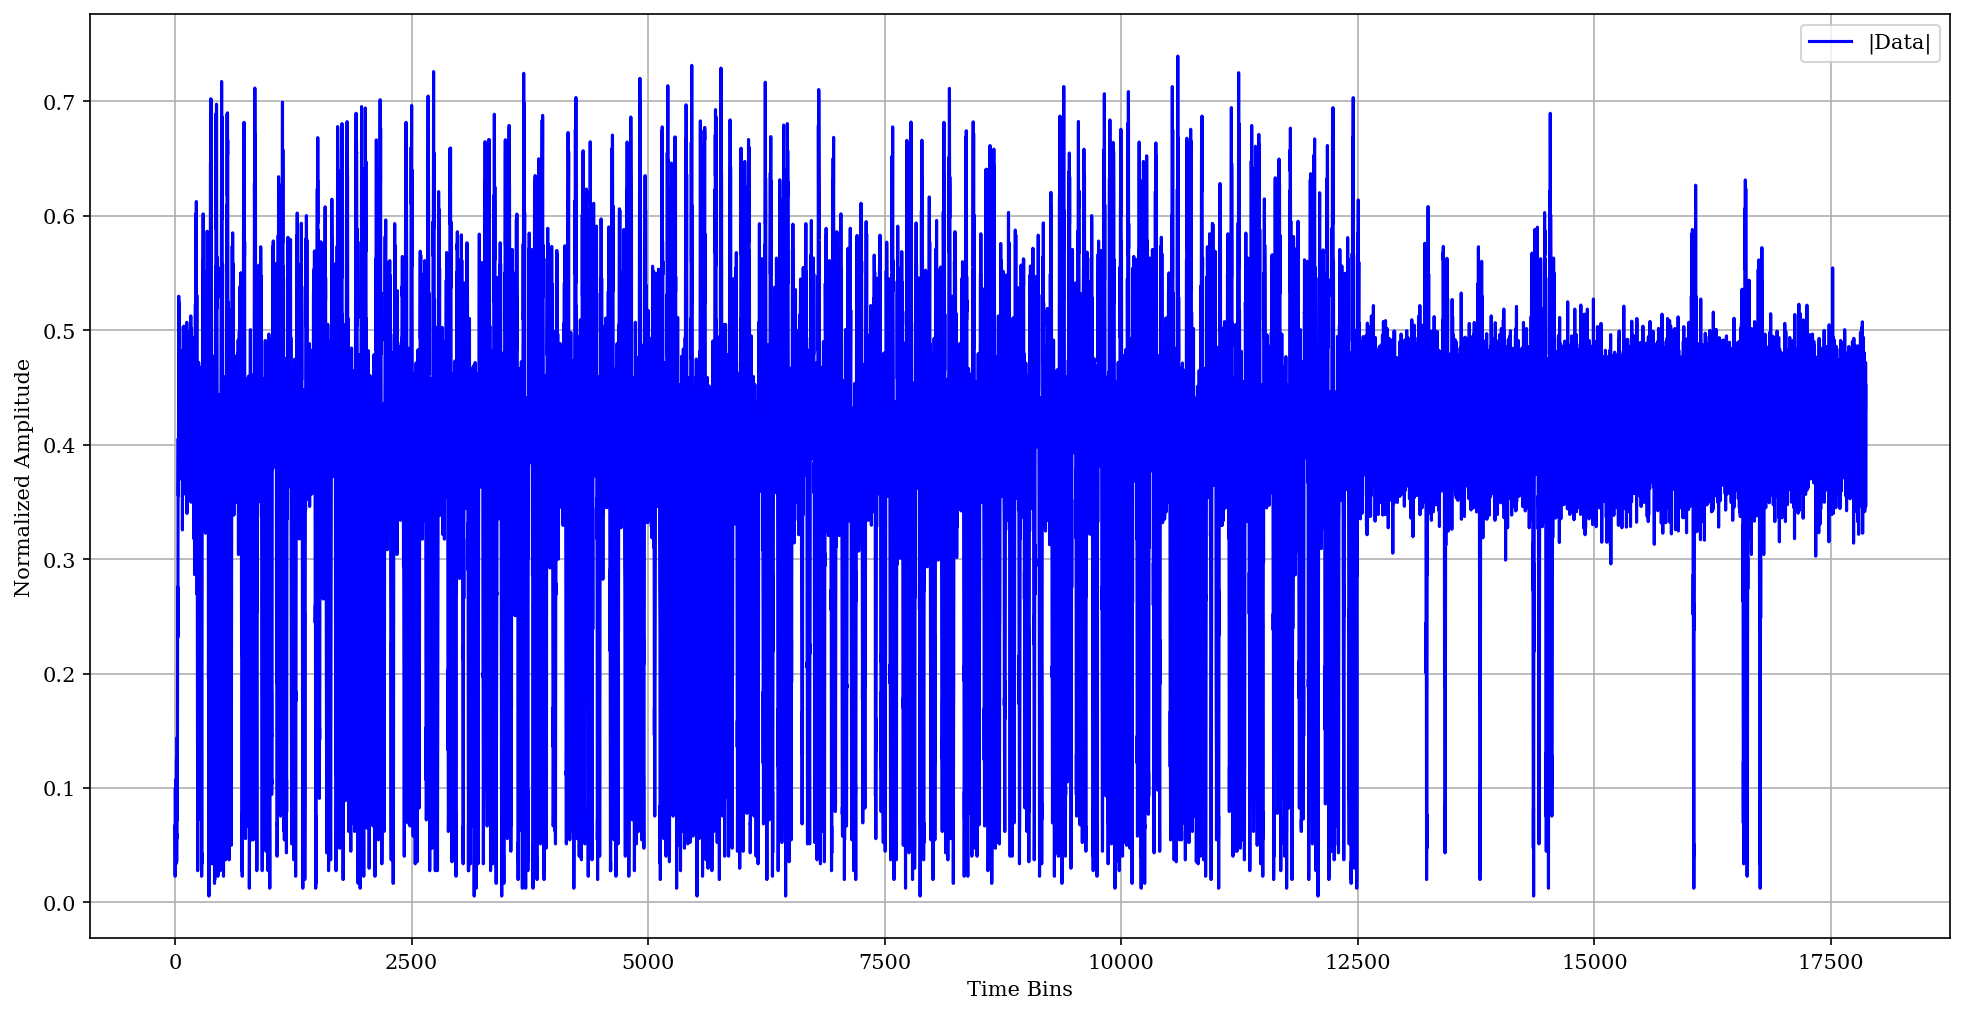

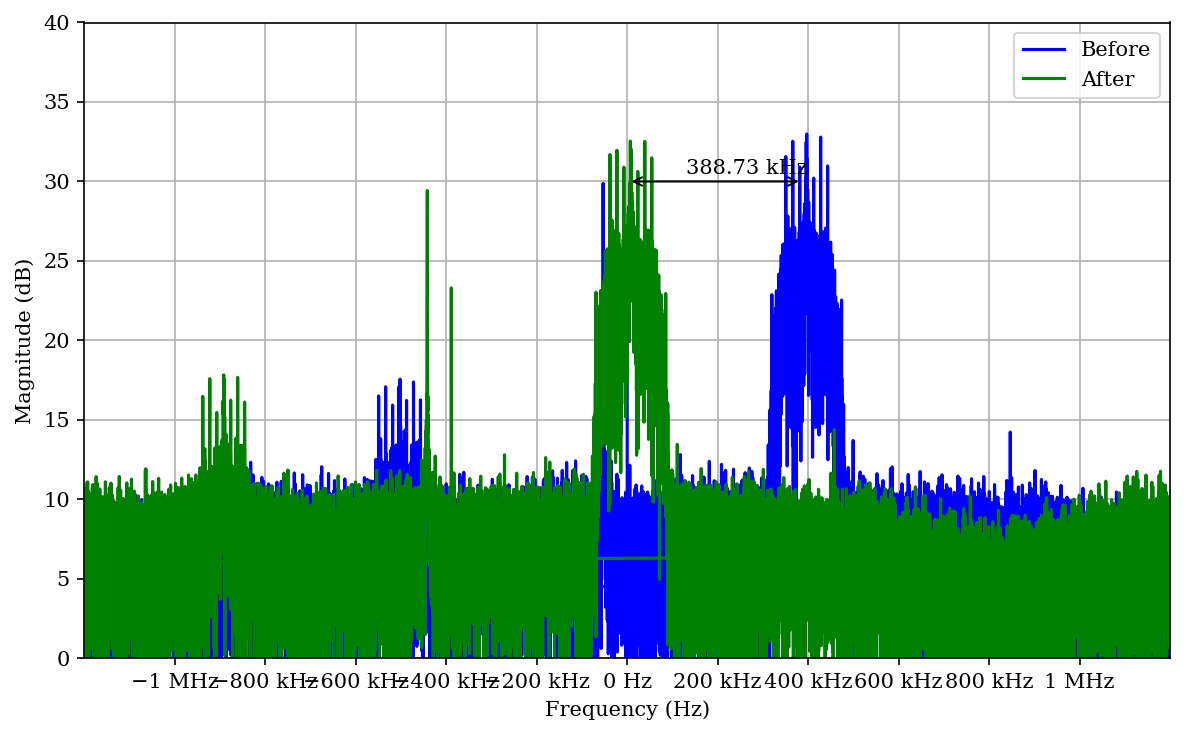

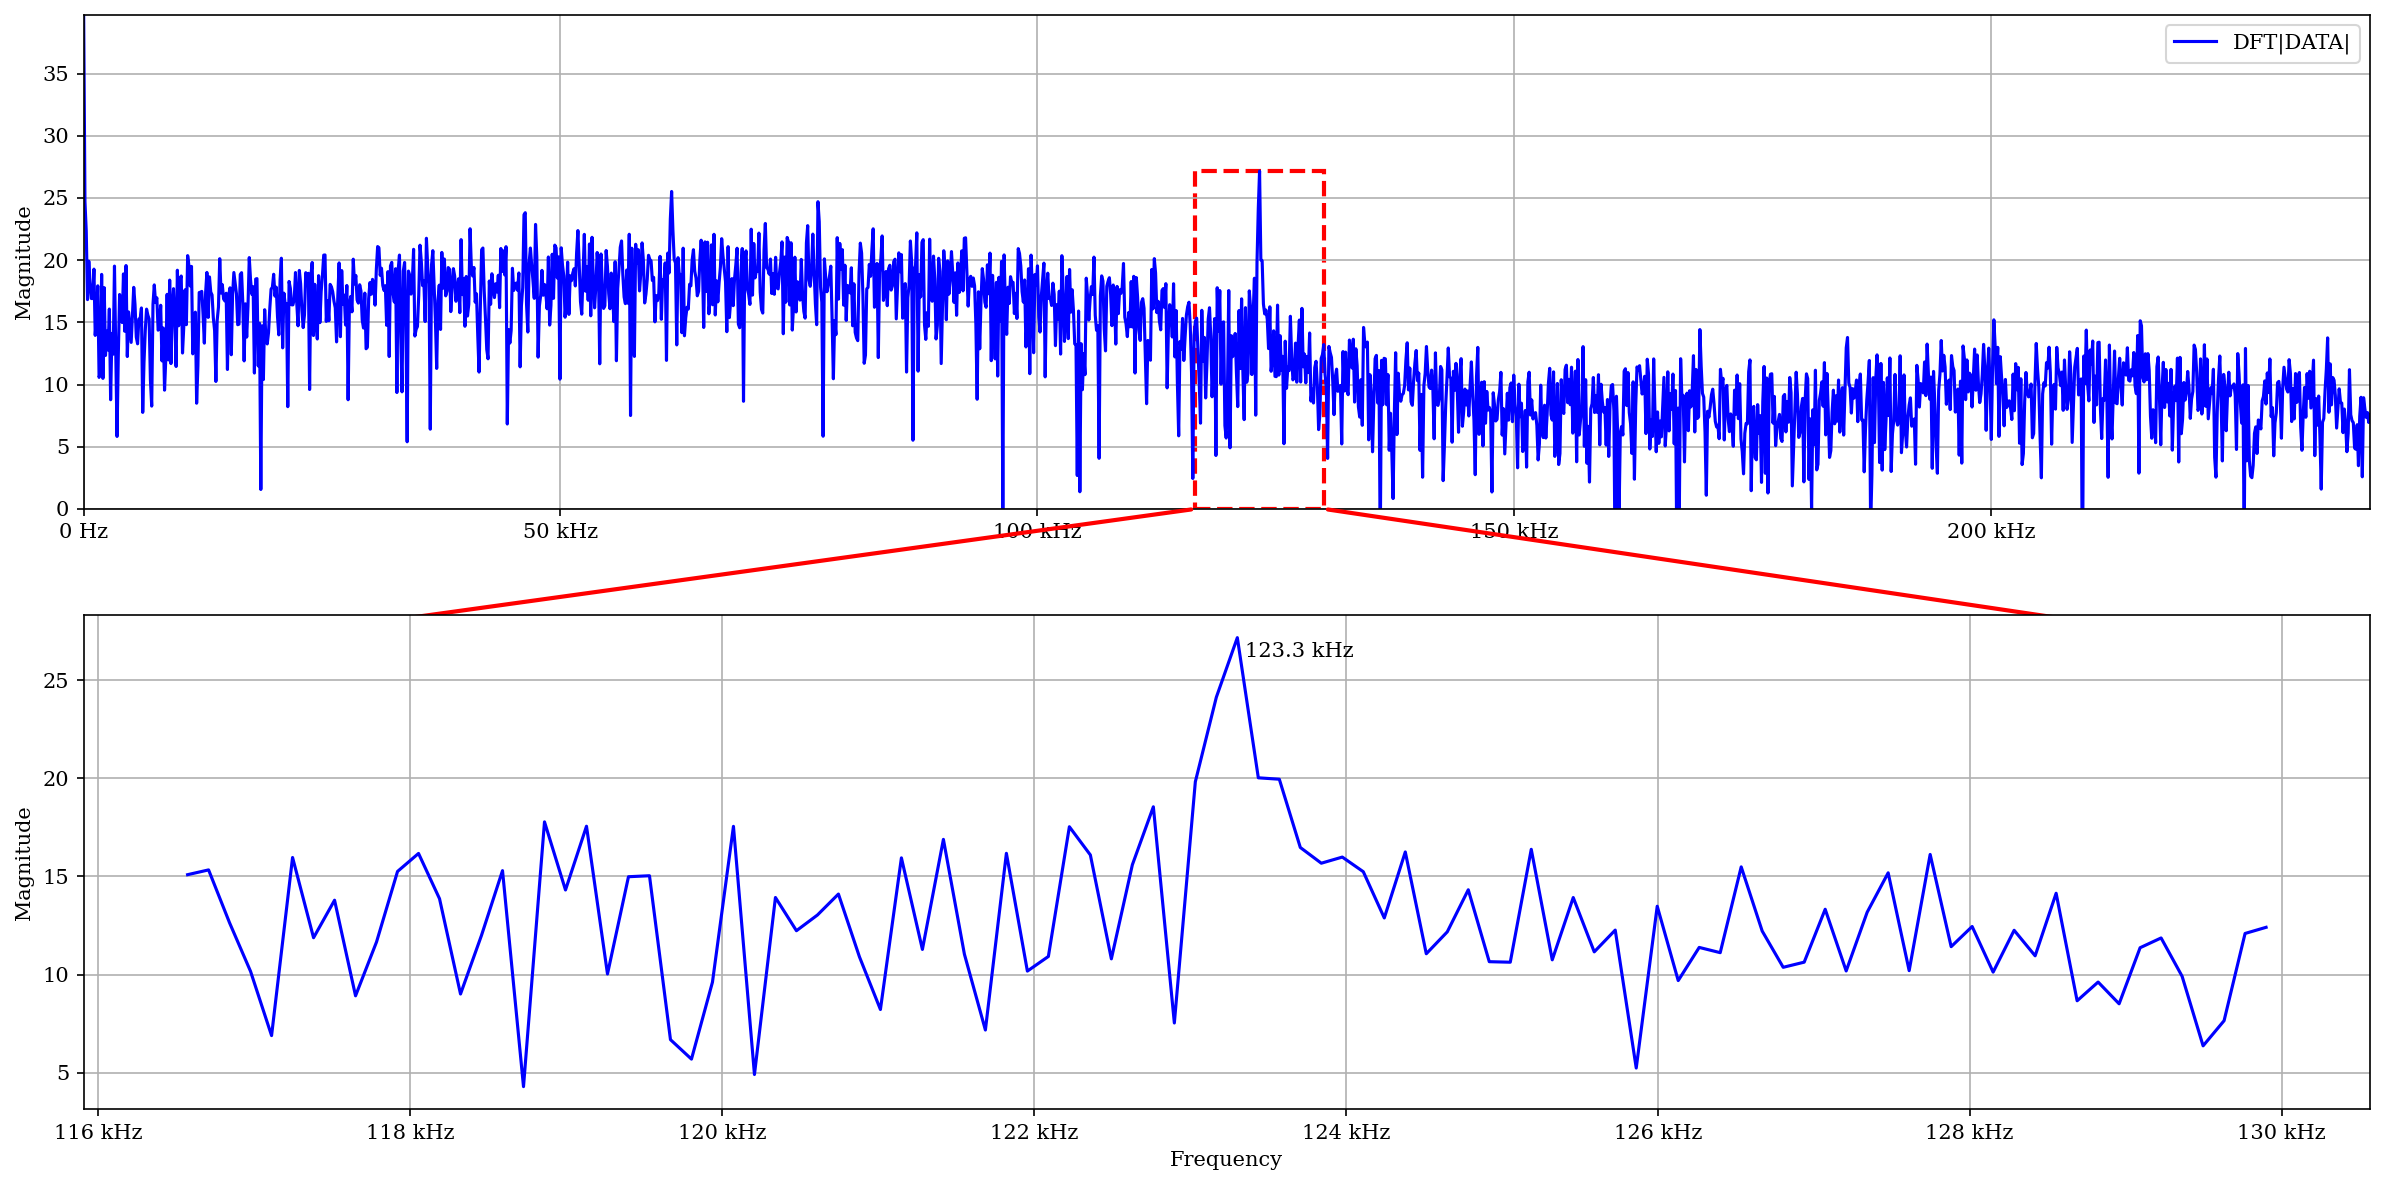

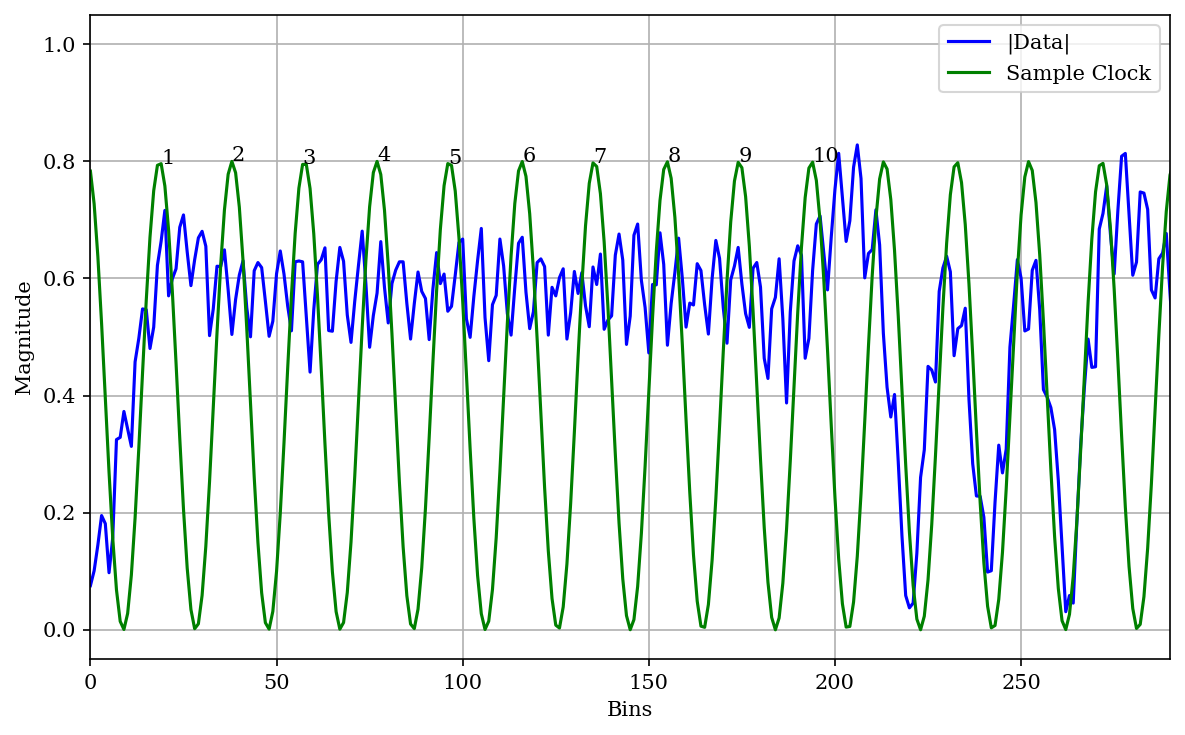

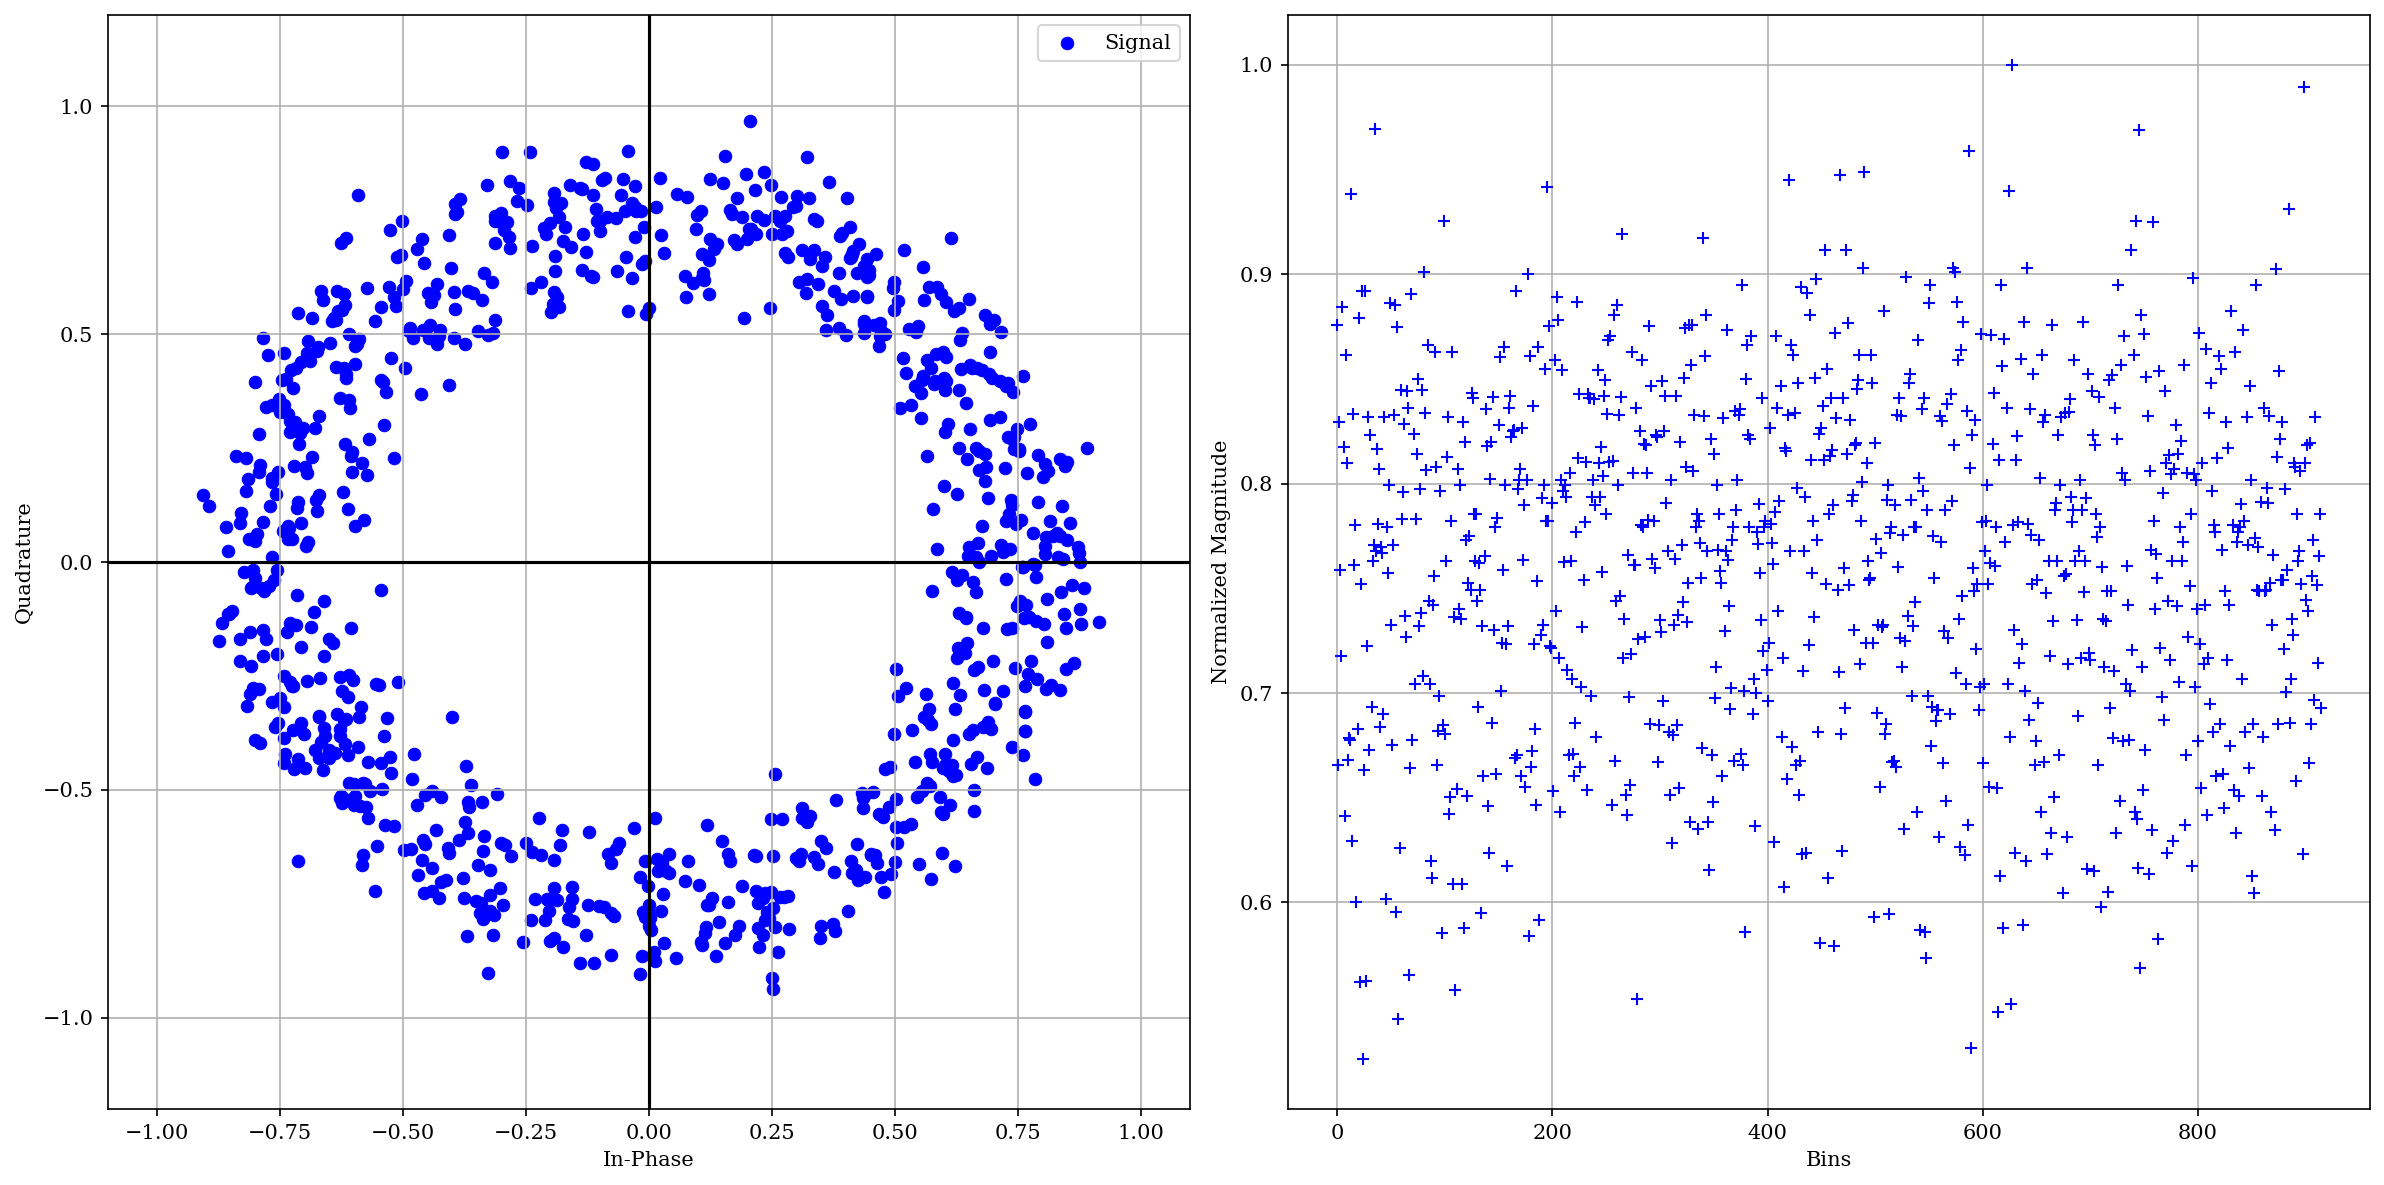

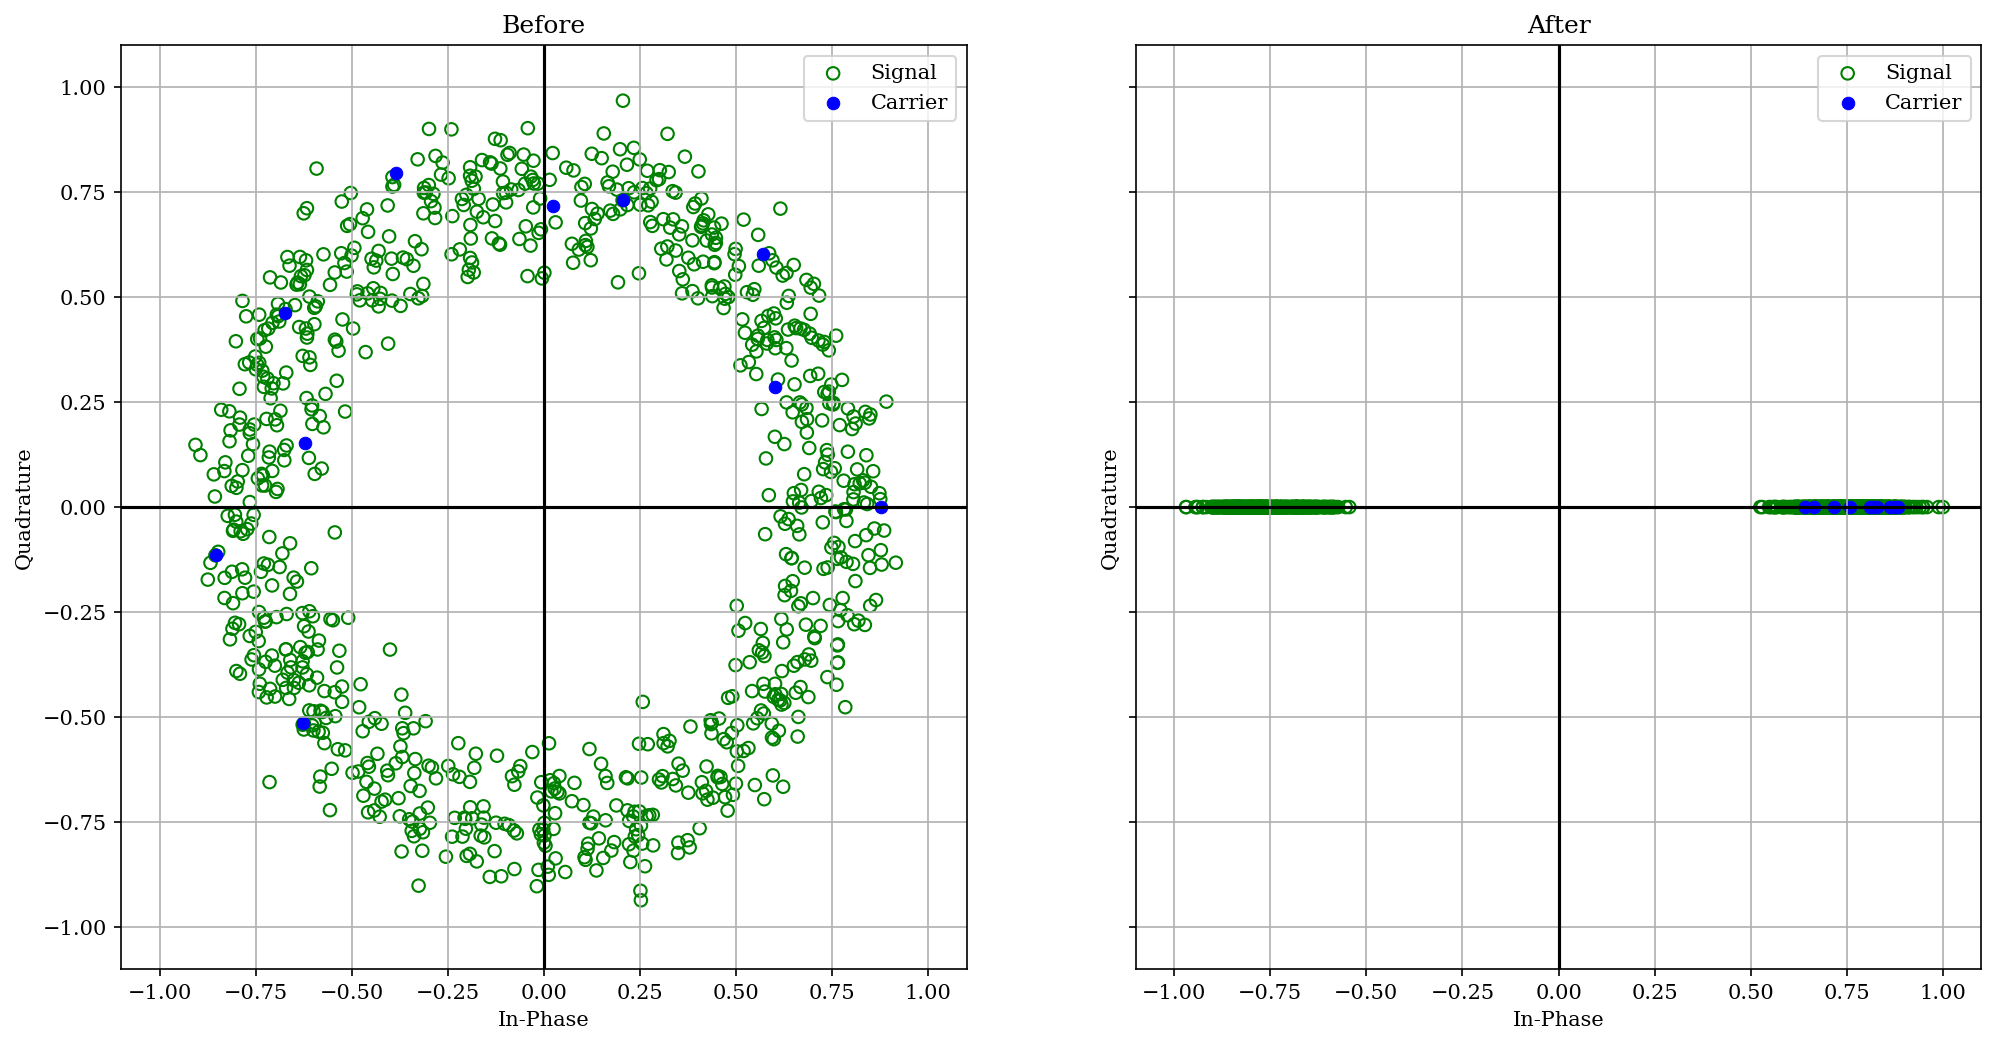

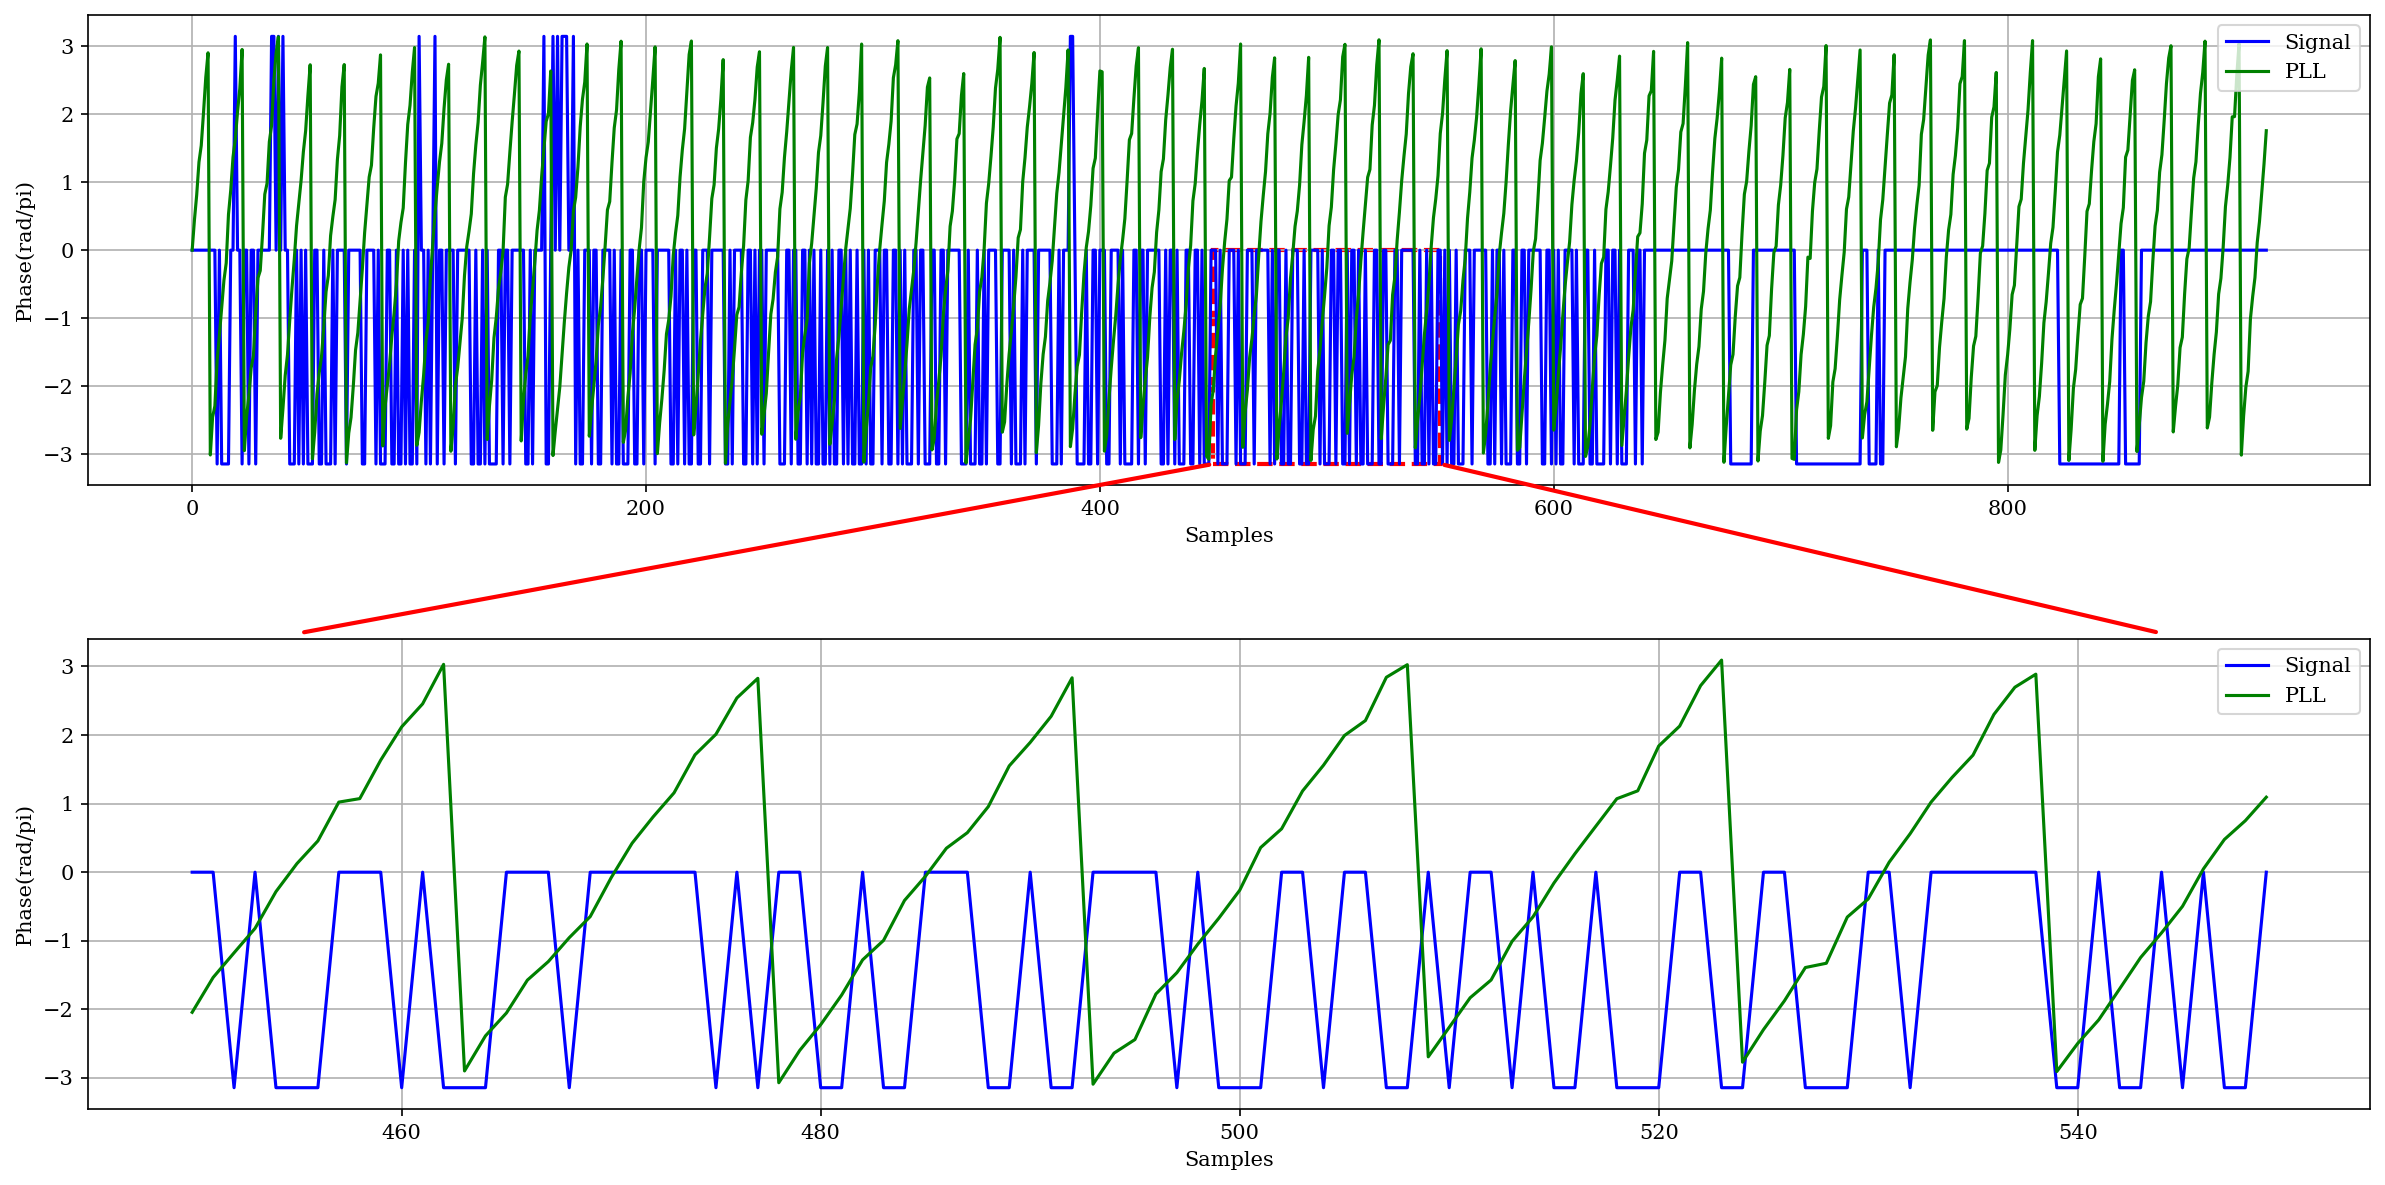

In [49]:
def zoomingBox(ax1, roi, ax2, color='red', linewidth=2):
    ax1.add_patch(Rectangle([roi[0],roi[2]], roi[1]-roi[0], roi[3]-roi[2],**dict([('fill',False), ('linestyle','dashed'), ('color',color), ('linewidth',linewidth)]) ))
    srcCorners = [[roi[0],roi[2]], [roi[0],roi[3]], [roi[1],roi[2]], [roi[1],roi[3]]]
    dstCorners = ax2.get_position().corners()
    srcBB = ax1.get_position()
    dstBB = ax2.get_position()
    if (dstBB.min[0]>srcBB.max[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.max[0]<srcBB.min[0] and dstBB.min[1]>srcBB.max[1]):
        src = [0, 3]; dst = [0, 3]
    elif (dstBB.max[0]<srcBB.min[0] and dstBB.max[1]<srcBB.min[1]) or (dstBB.min[0]>srcBB.max[0] and dstBB.min[1]>srcBB.max[1]):
        src = [1, 2]; dst = [1, 2]
    elif dstBB.max[1] < srcBB.min[1]:
        src = [0, 2]; dst = [1, 3]
    elif dstBB.min[1] > srcBB.max[1]:
        src = [1, 3]; dst = [0, 2]
    elif dstBB.max[0] < srcBB.min[0]:
        src = [0, 1]; dst = [2, 3]
    elif dstBB.min[0] > srcBB.max[0]:
        src = [2, 3]; dst = [0, 1]
    for k in range(2):
        ax1.annotate('', xy=dstCorners[dst[k]], xytext=srcCorners[src[k]], xycoords='figure fraction', textcoords='data', arrowprops=dict([('arrowstyle','-'), ('color',color), ('linewidth',linewidth)]))

freq_tick = np.arange(-1E8,1E8,200E3)

plt.figure(1)
plt.plot(np.abs(complex_data[start-20:end+20]),label = '|Data|')
plt.xlabel("Time Bins")
plt.ylabel("Normalized Amplitude")
plt.legend(loc='upper right')
plt.grid()

fig2, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)
ax.xaxis.set_major_formatter(formatter0)
ax.set_xticks(freq_tick)

ax.plot(freq,DATA_MAG_O,label="Before")
ax.plot(freq,DATA_MAG,label="After")

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Magnitude (dB)")

ax.set_ylim(0,40)
ax.set_xlim(min(freq),max(freq))

ax.annotate("", xy=(0, 30), xycoords='data',xytext=(Δ_f,30), textcoords='data',arrowprops=dict(arrowstyle="<->",connectionstyle="arc3"),)
ax.annotate(Quantity(Δ_f,'Hz'),xy=(0,0), xycoords='data',xytext=(Δ_f/3,30.5), textcoords='data')
ax.legend(loc='upper right')
ax.grid()


freq_tick = np.arange(0,600E3,50E3)
  
fig3, (ax1, ax2) = plt.subplots(2, 1,tight_layout=True)
ax1.plot(freq[:len(freq)//10],DATA_MAG_ABS[:len(freq)//10],label='DFT|DATA|')
ax1.xaxis.set_major_formatter(formatter0)
ax1.set_xticks(freq_tick)
ax1.set_ylabel("Magnitude")
ax1.set_ylim(0,max(DATA_MAG_ABS))
ax1.set_xlim(0,max(freq[len(freq)//10-1:len(freq)//10]))
ax1.legend(loc='upper right')
ax1.grid()
ax2.xaxis.set_major_formatter(formatter0)
ax2.plot(freq[Index_max-50:Index_max+50],DATA_MAG_ABS[Index_max-50:Index_max+50])
ax2.annotate(Quantity(freq[Index_max],'Hz'),xy=(freq[Index_max],DATA_MAG_ABS[Index_max]-1), xycoords='data',xytext=(freq[Index_max]+50,DATA_MAG_ABS[Index_max]-1), textcoords='data')
ax2.set_xlabel("Frequency")
ax2.set_ylabel("Magnitude")
ax2.grid()
zoomingBox(ax1, [freq[Index_max-50],freq[Index_max+50],0,DATA_MAG_ABS[Index_max]], ax2)


freq_tick = np.arange(-1E8,1E8,200E3)

fig4, ax = plt.subplots(1, 1, figsize=(8, 5), tight_layout=True)
ax.plot(bins,np.abs(DATA_signal),label="|Data|")
ax.plot(bins,np.real(NCO),label="Sample Clock")
ax.set_xlabel("Bins")
ax.set_ylabel("Magnitude")
ax.set_xlim(0,290)
for i in range(10):
    b = peak_bins[0][i]
    ax.annotate((i+1),(b,np.real(NCO[b])))
ax.legend(loc='upper right')
ax.grid()

fig5, (ax1, ax2) = plt.subplots(1, 2,tight_layout=True)
ax1.scatter(np.real(norm_data),np.imag(norm_data) ,linewidths=0.5,label='Signal')
ax1.set_xlabel("In-Phase")
ax1.set_ylabel("Quadrature")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.axhline(y=0,c='k')
ax1.axvline(x=0,c='k')
ax1.legend(loc='upper right')
ax1.grid()

ax2.plot(np.abs(norm_data),'b+')
ax2.set_xlabel("Bins")
ax1.set_ylim(-1.2,1.2)
ax2.set_ylabel("Normalized Magnitude")
ax2.grid()


fig6, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(np.real(norm_data[10:]),np.imag(norm_data[10:]),facecolors='none',edgecolors='g',label='Signal')
ax1.scatter(np.real(norm_data[:10]),np.imag(norm_data[:10]) ,linewidths=0.5,label='Carrier')
ax1.set_xlabel("In-Phase")
ax1.set_ylabel("Quadrature")
ax1.set_title("Before")
ax1.set_xlim(-1.1,1.1)
ax1.set_ylim(-1.1,1.1)
ax1.axhline(y=0,c='k')
ax1.axvline(x=0,c='k')
ax1.legend(loc='upper right')
ax1.grid()
ax2.scatter(np.real(sd_after[10:]),np.imag(sd_after[10:]) ,facecolors='none',edgecolors='g',label='Signal')
ax2.scatter(np.real(sd_after[:10]),np.imag(sd_after[:10]) ,linewidths=0.5,label='Carrier')
ax2.set_xlabel("In-Phase") 
ax2.set_ylabel("Quadrature")
ax2.set_title("After")
ax2.set_xlim(-1.1,1.1)
ax2.set_ylim(-1.1,1.1)
ax2.axhline(y=0,c='k')
ax2.axvline(x=0,c='k')
ax2.legend(loc='upper right')
ax2.grid()
plt.show()

sample_bins = np.arange(0,len(norm_data),1)

fig7, (ax1, ax2) = plt.subplots(2, 1,tight_layout=True)
θ_norm = np.angle(sd_after)
ϕ_PLL = np.angle(PLL)
zoomingBox(ax1,[450,550,min(θ_norm[450:550]),max(θ_norm[450:550])], ax2)

ax1.plot(sample_bins,θ_norm,label = 'Signal')
ax1.plot(sample_bins,-1*ϕ_PLL,label = 'PLL')        
ax1.set_xlabel("Samples")
ax1.set_ylabel("Phase(rad/pi)")
ax1.legend(loc='upper right')
ax1.grid()


ax2.plot(sample_bins[450:550],θ_norm[450:550],label = 'Signal')
ax2.plot(sample_bins[450:550],-1*ϕ_PLL[450:550],label = 'PLL') 
ax2.set_xlabel("Samples")
ax2.set_ylabel("Phase(rad/pi)")
ax2.legend(loc='upper right')
ax2.grid()

